### Analysis of subreddit title dataset

Goal: Analyzing the subreddit dataset for Structural Balance Theory on longitudinal data setting. We compute the dynamical networks evolving over time and predict its dynamics using SBT with Markov Chain model and Convex optimization estimation method.


https://snap.stanford.edu/data/soc-RedditHyperlinks.html

The hyperlink network represents the directed connections between two subreddits (a subreddit is a community on Reddit). We also provide subreddit embeddings. The network is extracted from publicly available Reddit data of 2.5 years from Jan 2014 to April 2017.

Subreddit Hyperlink Network: the subreddit-to-subreddit hyperlink network is extracted from the posts that create hyperlinks from one subreddit to another. We say a hyperlink originates from a post in the source community and links to a post in the target community. Each hyperlink is annotated with three properties: the timestamp, the sentiment of the source community post towards the target community post, and the text property vector of the source post. The network is directed, signed, temporal, and attributed.

Note that each post has a title and a body. The hyperlink can be present in either the title of the post or in the body. Therefore, we provide one network file for each.

Subreddit Embeddings: We have also provided embedding vectors representing each subreddit. These can be found in this dataset link: subreddit embedding dataset. Please note that some subreddit embeddings could not be generated, so this file has 51,278 embeddings.

Project website: These files have been generated as part of the research project on how subreddits attack one another. The details of the project can be found here.



Dataset statistics
Number of nodes (subreddits)	55,863
Number of edges (hyperlink between subreddits)	858,490
Edge weights (label of hyperlink)	-1 or +1
Edge attributes	Text property vectors
Timespan	Jan 2014 - April 2017


# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

from time import time
from typing import Text
import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import imp
import os
import pickle as pk
from pyvis.network import Network
%matplotlib inline

import sys
sys.path.insert(0, '../../../src/')

import network_utils
import utils

# Helper functions

In [2]:
def reload():
    imp.reload(network_utils)
    imp.reload(utils)

In [3]:
class Timer():
    def __init__(self, message: Text = None):
        if message:
            self.message = message
        else:
            self.message = 'It took {elapsed_time:.2f} {unit}.'

    def __enter__(self):
        self.start = time()
        return None

    def __exit__(self, type, value, traceback):
        elapsed_time = time() - self.start
        if elapsed_time < 60:
            unit = 'seconds'
        elif elapsed_time < 3600:
            unit = 'minutes'
            elapsed_time /= 60.0
        else:
            unit = 'hours'
            elapsed_time /= 3600.0
        print(
            self.message.format(elapsed_time=elapsed_time, unit=unit))
        

# Parameters

In [4]:
title_dataset_file_path = '/home/omid/Datasets/Subreddit/soc-redditHyperlinks-title.tsv'
weeks = 12

# Data loading

In [5]:
data = pd.read_csv(title_dataset_file_path, sep='\t')
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.rename(
    columns={
        'TIMESTAMP': 'edge_date',
        'SOURCE_SUBREDDIT': 'source',
        'TARGET_SUBREDDIT': 'target',
        'LINK_SENTIMENT': 'weight'}, inplace=True)

In [6]:
data.head()

,source,target,POST_ID,edge_date,weight,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [7]:
print(data.shape)

(571927, 6)


# Data basic analysis

In [8]:
print('Edges signs are: ', np.unique(data['weight']))

Edges signs are:  [-1  1]


In [9]:
print('How many edges are given from a source to target more than once over time: ',
      len(np.where(data[['source', 'target']].duplicated())[0]))

How many edges are given from a source to target more than once over time:  337135


In [10]:
data_len = len(data)
print('Data has {} #edges.\nIt spans from {} to {}.\n'
      'It has {} #nodes (unique) in total duration.'.format(
          data_len,
          min(data['edge_date']),
          max(data['edge_date']),
          len(set(data['source']).union(set(data['target'])))))

pos = len(np.where(data['weight'] > 0)[0])
neg = len(np.where(data['weight'] < 0)[0])
zer = len(np.where(data['weight'] == 0)[0])  # It should not be any zeros.
print('\nEdge over time:\n\t+:'
      ' {}({}%)\n\t-: {}({}%)\n\t0: {}({}%).'.format(
          pos, round(100*pos/data_len),
          neg, round(100*neg/data_len),
          zer, round(100*zer/data_len)))

Data has 571927 #edges.
It spans from 2013-12-31 16:20:20 to 2017-04-30 16:47:50.
It has 54075 #nodes (unique) in total duration.

Edge over time:
	+: 510787(89%)
	-: 61140(11%)
	0: 0(0%).


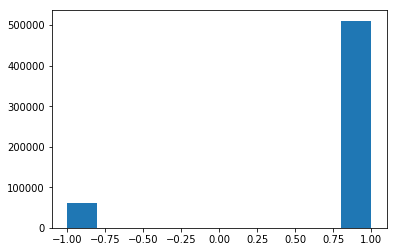

In [11]:
plt.hist(data['weight']);

# Extracting the networks

In [12]:
with Timer():
    separate_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=False, sum_multiple_edge=True)
    accumulative_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=True, sum_multiple_edge=True)

It took 19.48 seconds.


In [ ]:
# Saves the networks.
with open('/home/omid/Datasets/Subreddit/networks_avg.pkl', 'wb') as f:
    pk.dump({'separate_dgraphs': separate_dgraphs, 'accumulative_dgraphs': accumulative_dgraphs}, f)

# Plotting

In [ ]:
sns.set(rc={'figure.figsize':(8, 8)})
G = separate_dgraphs[0]

colors = []
for edge in G.edges():
    weight = G.get_edge_data(edge[0], edge[1])['weight']
    if weight == 0:
        colors.append('b')
    elif weight > 0:
        colors.append('g')
    else:
        colors.append('r')

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=30,
                       node_color='k',
                       cmap=plt.cm.Greys)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors)
plt.show()

In [ ]:
G = Network(directed=True, notebook=True)
G.from_nx(separate_dgraphs[0])
G.show_buttons(filter_=['physics'])
G.show("mygraph.html")

In [ ]:
# Just to create title names.
title_names = []
start_date = min(data['edge_date'])
end_date = max(data['edge_date'])
periods_num = int(np.floor((end_date - start_date).days / (weeks * 7)))
for period_index in range(periods_num):
    period_start = (
        start_date + period_index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    title_names.append('{} to {}'.format(period_start, period_end))

network_utils.plot_evolving_graphs(dgraphs=separate_dgraphs, titles=title_names)

# Computing the metrics for networks in periods

## Metrics for separate dynamic graphs

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(separate_dgraphs[0]).keys())

evolving_metrics = collections.defaultdict(list)
for index, directed_graph in enumerate(separate_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(directed_graph)
    for key in sorted_keys:
        evolving_metrics[key].append(metrics[key])

In [ ]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(evolving_metrics['#pos edges'], 'g')
plt.plot(evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(evolving_metrics['#gcc pos edges'], 'g')
plt.plot(evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

### Metrics for accumulative dynamic graphs

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(accumulative_dgraphs[0]).keys())

accumulative_evolving_metrics = collections.defaultdict(list)
for index, accumulative_dgraph in enumerate(accumulative_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(accumulative_dgraph)
    for key in sorted_keys:
        accumulative_evolving_metrics[key].append(metrics[key])

In [ ]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(accumulative_evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(accumulative_evolving_metrics['#pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(accumulative_evolving_metrics['#gcc pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(accumulative_evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

## Separated graphs

In [ ]:
start_time = time.time()

edge_balances = []
for separate_dgraph in separate_dgraphs:
    edge_balances.append(
        network_utils.compute_edge_balance(separate_dgraph))

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

In [ ]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, edge_balance in enumerate(edge_balances):
    num_unbalanced = []
    for value in edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

In [ ]:
transitions_balance = collections.defaultdict(list)
# transitions_div_unbalance = collections.defaultdict(list)
for edge_balance in edge_balances:
    for key, value in edge_balance.items():
        transitions_balance[key].append(value['#balanced']/value['#cycle3'])
#         transitions_div_unbalance[key].append(1 - value['#balanced'] / value['#cycle3'])


balanced_cycle3_ratio = []
for val in transitions_balance.values():
    if len(val) > 12:
        balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
balanced_cycle3_ratio = np.array(balanced_cycle3_ratio)
n, m =balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(balanced_cycle3_ratio, axis=0),
             yerr=np.std(balanced_cycle3_ratio, axis=0)/np.sqrt(n));

## Accumulative graphs

In [ ]:
accumulative_edge_balances = []
for accumulative_dgraph in accumulative_dgraphs:
    accumulative_edge_balances.append(
        network_utils.compute_edge_balance(accumulative_dgraph))

In [ ]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, accumulative_edge_balance in enumerate(accumulative_edge_balances):
    num_unbalanced = []
    for value in accumulative_edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

In [ ]:
acc_transitions_balance = collections.defaultdict(list)
for accumulative_edge_balance in accumulative_edge_balances:
    for key, value in accumulative_edge_balance.items():
        acc_transitions_balance[key].append(value['#balanced'] / value['#cycle3'])

acc_balanced_cycle3_ratio = []
for val in acc_transitions_balance.values():
    if len(val) > 12:
        acc_balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
acc_balanced_cycle3_ratio = np.array(acc_balanced_cycle3_ratio)
n, m = acc_balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(acc_balanced_cycle3_ratio, axis=0),
             yerr=np.std(acc_balanced_cycle3_ratio, axis=0)/np.sqrt(n));

# Markov Chain of Sparse Triads

In [13]:
triad_map, triad_list = network_utils.generate_all_possible_sparse_triads()
unique_triad_num = len(triad_list)

## Separated graphs

In [ ]:
with Timer():
    result = network_utils.compute_transition_matrix(
        dgraphs=separate_dgraphs,
        unique_triad_num=unique_triad_num,
        triad_map=triad_map,
        verbose=False)

In [ ]:
# Saves the transitions.
with open('/local/home/student/omid55/sbt_data_saved/transitions_avg.pkl', 'wb') as f:
    pk.dump(result, f)

In [ ]:
for transition_matrix in result['transition_matrices']:
    sns.set(rc={'figure.figsize': (10, 10)})
    print('Nonzero percentage: ', round(100 * len(np.where(transition_matrix > 0)[0]) / (unique_triad_num * unique_triad_num), 2), '%')
    sns.heatmap(transition_matrix, cmap="YlGnBu", linewidths=.1)
    plt.show()

In [ ]:
# for transition_matrix in result['transition_matrices']:
#     sns.set(rc={'figure.figsize': (8, 8)})
#     plt.plot(np.sum(transition_matrix, axis=0))

In [ ]:
sns.set(rc={'figure.figsize': (8, 8)})
for transition_matrix in result['transition_matrices']:
    st_dist = network_utils.get_stationary_distribution(transition_matrix)
    plt.plot(st_dist)

In [ ]:
mean_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
std_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in result['transition_matrices']:
            item_ij.append(matrix[i, j])
        mean_transition_matrix[i, j] = np.mean(item_ij)
        std_transition_matrix[i, j] = np.std(item_ij)

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(mean_transition_matrix, cmap="YlGnBu", linewidths=.1);

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(std_transition_matrix, cmap="YlGnBu", linewidths=.1);

In [ ]:
sns.set(rc={'figure.figsize': (8, 8)})
st_dist = network_utils.get_stationary_distribution(mean_transition_matrix)
plt.plot(st_dist)

In [ ]:
for index in np.where(st_dist >= np.mean(st_dist))[0]:
    print(triad_list[index])
    print('\n')

## Accumulated graphs 

In [ ]:
start_time = time.time()

acc_result = network_utils.compute_transition_matrix(
    dgraphs=accumulative_dgraphs,
    unique_triad_num=unique_triad_num,
    triad_map=triad_map,
    verbose=True)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

In [ ]:
# Saves the accumulative transitions.
with open('/local/home/student/omid55/sbt_data_saved/acc_transitions_avg.pkl', 'wb') as f:
    pk.dump(acc_result, f)

In [ ]:
for transition_matrix in acc_result['transition_matrices']:
    sns.set(rc={'figure.figsize': (10, 10)})
    print('Nonzero percentage: ', round(100 * len(np.where(transition_matrix > 0)[0]) / (unique_triad_num * unique_triad_num), 2), '%')
    sns.heatmap(transition_matrix, cmap="YlGnBu", linewidths=.1)
    plt.show()

In [ ]:
# for transition_matrix in acc_result['transition_matrices']:
#     sns.set(rc={'figure.figsize': (8, 8)})
#     plt.plot(np.sum(transition_matrix, axis=0))

In [ ]:
sns.set(rc={'figure.figsize': (10, 10)})
st_dists = []
for transition_matrix in acc_result['transition_matrices']:
    st_dist = network_utils.get_stationary_distribution(transition_matrix)
    st_dists.append(st_dist)
    plt.plot(st_dist)
# plt.legend(['P'+str(i) for i in range(1, 1+len(acc_result['transition_matrices']))])

In [ ]:
acc_mean_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
acc_std_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in acc_result['transition_matrices']:
            item_ij.append(matrix[i, j])
        acc_mean_transition_matrix[i, j] = np.mean(item_ij)
        acc_std_transition_matrix[i, j] = np.std(item_ij)

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_mean_transition_matrix, cmap="YlGnBu", linewidths=.1);

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_std_transition_matrix, cmap="YlGnBu", linewidths=.1);

In [ ]:
sns.set(rc={'figure.figsize': (8, 8)})
acc_st_dist = network_utils.get_stationary_distribution(acc_mean_transition_matrix)
plt.plot(acc_st_dist, 'p');

In [ ]:
for index in np.where(acc_st_dist >= 0.06)[0]:
    print(triad_list[index])
    print('\n')

In [ ]:
for index in np.where(acc_st_dist >= np.mean(acc_st_dist))[0]:
    print(triad_list[index])
    print('\n')

# Convex estimating the transition matrices

In [ ]:
def get_array_of_138(a):
    r = a
    if len(a) < 138:
        r = np.array(list(a) + [0 for i in range(138 - len(a))])
    return r

def get_matrix_stochastic(a):
    a = a / np.sum(a)
    return np.matrix(a)

In [ ]:
l = 40
loaded_d = utils.load_it('/home/omid/Downloads/DT/cvx_data.pk')
obs = loaded_d['obs']
T = loaded_d['T']

obs_mat = []
for o in obs:
    obs_mat.append(np.matrix(o))
    
obs_normalized = []
for o in obs:
    obs_normalized.append(get_matrix_stochastic(o))

### Convex optimization problem

In [ ]:
import cvxpy as cp

In [ ]:
# start_time = time.time()

# # l = 103
# n = 138
# lam1 = 0.4
# lam2 = 0.2
# lam3 = 0.1
# lam4 = 0.1

# # Variables.
# M = [cp.Variable(n, n) for _ in range(l-1)]

# # Objective function.
# term1 = 0
# for i in range(l-1):
# #     term1 += cp.norm2(obs_mat[i] * M[i] - obs_mat[i + 1])
#     term1 += cp.norm2(obs_normalized[i] * M[i] - obs_normalized[i + 1])

# term2 = 0
# for i in range(1, l-1):
#     term2 += cp.norm2(M[i] - M[i - 1])
# term2 *= lam1

# term3 = 0
# for i in range(1, l-1):
#     term3 += cp.norm1(M[i] - M[i - 1])
# term3 *= lam2

# # term3 = 0
# # for i in range(l-1):
# #     term3 += cp.norm2(M[i] - T[i])
# # term3 *= lam2

# # term4 = 0
# # for i in range(l-1):
# #     term4 += cp.norm1(M[i])
# # term4 *= lam3

# # term5 = 0
# # for i in range(l-1):
# #     term5 += cp.norm_nuc.normNuc(M[i])
# # term5 *= lam4

# objective = cp.Minimize(term1 + term2 + term3) #+ term4) # + term5)

# # Constraints.
# constraints = []
# for i in range(l-1):
#     constraints += (
#         [0 <= M[i],
#          M[i] <= 1,
#          M[i] * np.ones(n) == np.ones(n)])
# #          obs_normalized[i + 1] * M[i] == obs_normalized[i + 1]])
    
# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# # res = prob.solve(cp.SCS)
# # res = prob.solve(cp.CVXOPT)
# res = prob.solve(cp.MOSEK)
# # res = prob.solve()
# print(res)

# duration = time.time() - start_time
# print('It took :{} mins.'.format(round(duration/60, 2)))

In [ ]:
# start_time = time.time()

# # l = 103
# n = 138
# lam1 = 0.4
# lam2 = 0.2
# lam3 = 0.1
# lam4 = 0.1

# # Variables.
# M = [cp.Variable(n, n) for _ in range(l-1)]

# # Objective function.
# term1 = 0
# for i in range(l-1):
# #     term1 += cp.norm2(obs_mat[i] * M[i] - obs_mat[i + 1])
#     term1 += cp.norm2(obs_normalized[i] * M[i] - obs_normalized[i + 1])

# term2 = 0
# for i in range(1, l-1):
#     term2 += cp.norm1(M[i] - M[i - 1])
# term2 *= lam1

# # term3 = 0
# # for i in range(l-1):
# #     term3 += cp.norm2(M[i] - T[i])
# # term3 *= lam2

# # term4 = 0
# # for i in range(l-1):
# #     term4 += cp.norm1(M[i])
# # term4 *= lam3

# # term5 = 0
# # for i in range(l-1):
# #     term5 += cp.norm_nuc.normNuc(M[i])
# # term5 *= lam4

# objective = cp.Minimize(term1 + term2) #+ term3) #+ term4) # + term5)

# # Constraints.
# constraints = []
# for i in range(l-1):
#     constraints += (
#         [0 <= M[i],
#          M[i] <= 1,
#          M[i] * np.ones(n) == np.ones(n)])
# #          obs_normalized[i + 1] * M[i] == obs_normalized[i + 1]])
    
# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# # res = prob.solve(cp.SCS)
# # res = prob.solve(cp.CVXOPT)
# res = prob.solve(cp.MOSEK)
# # res = prob.solve()
# print(res)

# duration = time.time() - start_time
# print('It took :{} mins.'.format(round(duration/60, 2)))

In [ ]:
# start_time = time.time()

# # l = 103
# n = 138
# lam1 = 0.4
# lam2 = 0.2
# lam3 = 0.1
# lam4 = 0.1

# # Variables.
# M = [cp.Variable(n, n) for _ in range(l-1)]

# # Objective function.
# term1 = 0
# for i in range(l-1):
# #     term1 += cp.norm2(obs_mat[i] * M[i] - obs_mat[i + 1])
#     term1 += cp.norm2(obs_normalized[i] * M[i] - obs_normalized[i + 1])

# term2 = 0
# for i in range(1, l-1):
#     term2 += cp.norm2(M[i] - M[i - 1])
# term2 *= lam1

# # term3 = 0
# # for i in range(l-1):
# #     term3 += cp.norm2(M[i] - T[i])
# # term3 *= lam2

# # term4 = 0
# # for i in range(l-1):
# #     term4 += cp.norm1(M[i])
# # term4 *= lam3

# # term5 = 0
# # for i in range(l-1):
# #     term5 += cp.norm_nuc.normNuc(M[i])
# # term5 *= lam4

# objective = cp.Minimize(term1 + term2) #+ term3) #+ term4) # + term5)

# # Constraints.
# constraints = []
# for i in range(l-1):
#     constraints += (
#         [0 <= M[i],
#          M[i] <= 1,
#          M[i] * np.ones(n) == np.ones(n),
#          obs_normalized[i + 1] * M[i] == obs_normalized[i + 1]])
    
# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# # res = prob.solve(cp.SCS)
# # res = prob.solve(cp.CVXOPT)
# res = prob.solve(cp.MOSEK)
# # res = prob.solve()
# print(res)

# duration = time.time() - start_time
# print('It took :{} mins.'.format(round(duration/60, 2)))

In [ ]:
start_time = time.time()

# l = 103
n = 138
lam1 = 0.4
lam2 = 0.2
lam3 = 0.1
lam4 = 0.1

# Variables.
M = [cp.Variable(n, n) for _ in range(l-1)]

# Objective function.
term1 = 0
for i in range(l-1):
#     term1 += cp.norm2(obs_mat[i] * M[i] - obs_mat[i + 1])
    term1 += cp.norm2(obs_normalized[i] * M[i] - obs_normalized[i + 1])

term2 = 0
for i in range(1, l-1):
    term2 += cp.norm1(M[i] - M[i - 1])
term2 *= lam1

# term3 = 0
# for i in range(l-1):
#     term3 += cp.norm2(M[i] - T[i])
# term3 *= lam2

# term4 = 0
# for i in range(l-1):
#     term4 += cp.norm1(M[i])
# term4 *= lam3

# term5 = 0
# for i in range(l-1):
#     term5 += cp.norm_nuc.normNuc(M[i])
# term5 *= lam4

objective = cp.Minimize(term1 + term2) #+ term3) # + term5)

# Constraints.
constraints = []
for i in range(l-1):
    constraints += (
        [0 <= M[i],
         M[i] <= 1,
         M[i] * np.ones(n) == np.ones(n)])
    
# Problem.
prob = cp.Problem(objective, constraints)

# Solving the problem.
# res = prob.solve(cp.SCS)
# res = prob.solve(cp.CVXOPT)
res = prob.solve(cp.MOSEK)
# res = prob.solve()
print(res)

duration = time.time() - start_time
print('It took :{} mins.'.format(round(duration/60, 2)))

In [ ]:
l

In [ ]:
diff = []
for i in range(1, l-1):
    diff.append(np.linalg.norm(M[i].value - M[i-1].value))
plt.plot(diff);

In [ ]:
transitives = []
for triad in triad_list:
    transitives.append(network_utils.is_sparsely_transitive_balanced(triad))
transitives = np.array(transitives)

In [ ]:
ch = []
for triad in triad_list:
    ch.append(network_utils.is_sparsely_cartwright_harary_balanced(triad))
ch = np.array(ch)

In [ ]:
self_transitive_means = []
self_nontransitive_means = []
nontransitive_to_transitive_means = []
transitive_to_nontransitive_means = []
self_transitive_stds = []
self_nontransitive_stds = []
nontransitive_to_transitive_stds = []
transitive_to_nontransitive_stds = []

for matrix in M:
    trans_matrix = matrix.value
    
    probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
    self_transitive_means.append(np.mean(probs))
    self_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
    nontransitive_to_transitive_means.append(np.mean(probs))
    nontransitive_to_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
    transitive_to_nontransitive_means.append(np.mean(probs))
    transitive_to_nontransitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
    self_nontransitive_means.append(np.mean(probs))
    self_nontransitive_stds.append(np.std(probs))
    

plt.errorbar(x=np.arange(l-1), y=self_transitive_means, yerr=self_transitive_stds, fmt='r')
plt.errorbar(x=np.arange(l-1), y=nontransitive_to_transitive_means, yerr=nontransitive_to_transitive_stds, fmt='g')
plt.errorbar(x=np.arange(l-1), y=self_nontransitive_means, yerr=self_nontransitive_stds, fmt='b')
plt.errorbar(x=np.arange(l-1), y=transitive_to_nontransitive_means, yerr=transitive_to_nontransitive_stds, fmt='k')
plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);


# plt.errorbar(x=np.arange(39), y=self_transitive_means) #, yerr=self_transitive_stds)
# plt.errorbar(x=np.arange(39), y=nontransitive_to_transitive_means) #, yerr=nontransitive_to_transitive_stds)
# plt.errorbar(x=np.arange(39), y=self_nontransitive_means) #, yerr=self_nontransitive_stds)
# plt.errorbar(x=np.arange(39), y=transitive_to_nontransitive_means) #, yerr=transitive_to_nontransitive_stds)
# plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);

# Predicting future of each edge with respect to all triads that is involved in

## Separated 

In [ ]:
period_index = 0

dgraph = separate_dgraphs[period_index]
nodes = dgraph.nodes()
for edge in dgraph.edges():
    rest_of_nodes = list(set(nodes) - set(edge))
    for node in rest_of_nodes:
        triad_type = result['triads_types'][period_index][str(tuple(sorted([edge[0], edge[1], node])))]
        prob = result['transition_matrices'][period_index][triad_type, :]
        print(prob)
        break
    break

## Accumulative

# Predicting future transition and ratio of triads

In [ ]:
period_index = 0

matrix = acc_result['transition_matrices'][period_index]
triad_count = np.bincount(list(result['triads_types'][period_index].values()), minlength=138)
triad_count = triad_count / np.sum(triad_count)

In [ ]:
predicted_period_count = np.squeeze(np.asarray(np.matrix(triad_count) * np.matrix(matrix)))

In [ ]:
next_triad_count = np.bincount(list(result['triads_types'][period_index+1].values()), minlength=138)
next_triad_count = next_triad_count / np.sum(next_triad_count)

In [ ]:
sns.set(rc={'figure.figsize': (8, 8)})
plt.plot(np.array(abs(predicted_period_count - next_triad_count)));

## Timeseries prediction for transition matrices

In [ ]:
sns.set(rc={'figure.figsize': (100, 100)})
sns.set(font_scale=0.25)
c = 0
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        c += 1
        item_ij = []
        for matrix in result['transition_matrices']:
            item_ij.append(matrix[i, j])
        plt.subplot(unique_triad_num, unique_triad_num, c)
        plt.plot(item_ij)
        if c > 139:
            break
    if c > 139:
        break

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
leng = 4

rmses = 0
errors = {}
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in result['transition_matrices']:
            item_ij.append(matrix[i, j])
        # Timeseries forecasting.
        model = ARIMA(item_ij[:-leng], order=(2, 1, 0))
        model = model.fit()
        rmse = sqrt(mean_squared_error(item_ij[-leng:], model.forecast(steps=leng)[0]))
        errors[str((i, j))] = rmse
        rmses += rmse

In [ ]:
rmses / (unique_triad_num * unique_triad_num)

### Only for one item in the matrix

In [ ]:
i = 0
j = 0
item_ij = []
for matrix in result['transition_matrices']:
    item_ij.append(matrix[i, j])
# Timeseries forecasting.
model = ARIMA(item_ij[:-leng], order=(2, 1, 0))
model_fit = model.fit()

In [ ]:
plt.plot(item_ij)

In [ ]:
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
# residual = item_ij[-leng:] - fitted_model.forecast(steps=leng)[0]
# rmse = sqrt(mean_squared_error(item_ij[-leng:], fitted_model.forecast(steps=leng)[0]))
# print('RMSE: ', rmse)
# plt.plot(residual);

In [ ]:
# plt.plot(pd.rolling_mean(pd.DataFrame(item_ij), window=12))

In [ ]:
# plt.plot(pd.rolling_std(pd.DataFrame(item_ij), window=12));

# Cartwright & Harary balance

In [ ]:
# for separate_dgraph in separate_dgraphs:
#     print('cartwright & harary unbalance ratio: ',
#           network_utils.cartwright_harary_balance(separate_dgraph))

# How transition matrices change over time

In [ ]:
periods = network_utils.get_just_periods(edge_list=data, weeks=weeks, accumulative=False)

## L2-nrom distance of each matrix from the average transition matrix.

### Separated

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
l2norm_dists = []
for matrix in result['transition_matrices']:
    l2norm_dists.append(np.linalg.norm(matrix - mean_transition_matrix))
plt.plot(l2norm_dists)
plt.ylabel('L2-norm distance from average transition matrix.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(number_of_periods-1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

### Accumulative

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
acc_l2norm_dists = []
for matrix in acc_result['transition_matrices']:
    acc_l2norm_dists.append(np.linalg.norm(matrix - acc_mean_transition_matrix))
plt.plot(acc_l2norm_dists)
plt.ylabel('L2-norm distance from average transition matrix.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(number_of_periods-1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

## L2-nrom distance of each matrix from its previous one.

### Separated

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
from_prev_l2norm_dists = []
n = len(result['transition_matrices'])
for i in range(1, n):
    current = result['transition_matrices'][i]
    prev = result['transition_matrices'][i-1]
    from_prev_l2norm_dists.append(np.linalg.norm(prev - current))
plt.plot(from_prev_l2norm_dists)
plt.ylabel('L2-norm distance from each transition matrix from its previous one.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(number_of_periods-1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

### Accumulative

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
acc_from_prev_l2norm_dists = []
n = len(acc_result['transition_matrices'])
for i in range(1, n):
    current = acc_result['transition_matrices'][i]
    prev = acc_result['transition_matrices'][i-1]
    acc_from_prev_l2norm_dists.append(np.linalg.norm(prev - current))
plt.plot(acc_from_prev_l2norm_dists)
plt.ylabel('L2-norm distance from each transition matrix from its previous one.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(number_of_periods-1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

# Transitivity balance over time

In [ ]:
balanced = 0
transitive_balances = []
for triad in triad_list:
    bal = network_utils.is_sparsely_transitive_balanced(triad)
    transitive_balances.append(bal)
    if bal:
        balanced += 1

In [ ]:
print('Transitive balanced triads: ', balanced)
print('Out of triads: ', len(triad_list))

# CVX Optimized Transitivity analysis

In [ ]:
transitives = []
for triad in triad_list:
    transitives.append(network_utils.is_sparsely_transitive_balanced(triad))
transitives = np.array(transitives)

In [ ]:
trans_matrix = M[l-1-1].value

In [ ]:
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
plt.hist(probs)
plt.title(
    'Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))
plt.show()

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
plt.hist(probs)
plt.title('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))
plt.show()


probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
plt.title('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))
plt.show()

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
plt.title('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))
plt.show();

In [ ]:
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);

In [ ]:
self_transitive_means = []
self_nontransitive_means = []
nontransitive_to_transitive_means = []
transitive_to_nontransitive_means = []
self_transitive_stds = []
self_nontransitive_stds = []
nontransitive_to_transitive_stds = []
transitive_to_nontransitive_stds = []

for matrix in M:
    trans_matrix = matrix.value
    
    probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
    self_transitive_means.append(np.mean(probs))
    self_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
    nontransitive_to_transitive_means.append(np.mean(probs))
    nontransitive_to_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
    transitive_to_nontransitive_means.append(np.mean(probs))
    transitive_to_nontransitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
    self_nontransitive_means.append(np.mean(probs))
    self_nontransitive_stds.append(np.std(probs))
    

plt.errorbar(x=np.arange(l-1), y=self_transitive_means, yerr=self_transitive_stds, fmt='r')
plt.errorbar(x=np.arange(l-1), y=nontransitive_to_transitive_means, yerr=nontransitive_to_transitive_stds, fmt='g')
plt.errorbar(x=np.arange(l-1), y=self_nontransitive_means, yerr=self_nontransitive_stds, fmt='b')
plt.errorbar(x=np.arange(l-1), y=transitive_to_nontransitive_means, yerr=transitive_to_nontransitive_stds, fmt='k')
plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);


# plt.errorbar(x=np.arange(39), y=self_transitive_means) #, yerr=self_transitive_stds)
# plt.errorbar(x=np.arange(39), y=nontransitive_to_transitive_means) #, yerr=nontransitive_to_transitive_stds)
# plt.errorbar(x=np.arange(39), y=self_nontransitive_means) #, yerr=self_nontransitive_stds)
# plt.errorbar(x=np.arange(39), y=transitive_to_nontransitive_means) #, yerr=transitive_to_nontransitive_stds)
# plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);

## Separated 

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
transitivity_balance = []
for period_triads in result['triads_types']:
    balanced = 0.0
    for triad_index in period_triads.values():
        if transitive_balances[triad_index]:
            balanced += 1.0
    balanced /= len(period_triads)
    transitivity_balance.append(balanced)
plt.plot(transitivity_balance)
plt.ylabel('Transitivity Balance Ratio.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}]'.format(periods[i][0][:7], periods[i][1][:7]) for i in range(number_of_periods)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

## Accumulative 

In [ ]:
sns.set(rc={'figure.figsize': (60, 20)})
acc_transitivity_balance = []
for period_triads in acc_result['triads_types']:
    balanced = 0.0
    for triad_index in period_triads.values():
        if transitive_balances[triad_index]:
            balanced += 1.0
    balanced /= len(period_triads)
    acc_transitivity_balance.append(balanced)
plt.plot(acc_transitivity_balance)
plt.ylabel('Transitivity Balance Ratio.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}]'.format(periods[i][0][:7], periods[i][1][:7]) for i in range(number_of_periods)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

# Van De Rijt balance

In [ ]:
edge_balances = []
for separate_dgraph in separate_dgraphs:
    edge_balances.append(network_utils.compute_vanderijt_edge_balance(separate_dgraph))

In [ ]:
network_mean_balance = []
for index, edge_balance in enumerate(edge_balances):
    balanced_edges = list(np.ones(
        len(set(separate_dgraphs[index].edges()) - set(edge_balance.keys()))))
    network_mean_balance.append(
        np.mean(balanced_edges + [item['#balanced_node3'] / item['#nodes3']
                 for item in list(edge_balance.values())]))

In [ ]:
plt.plot(network_mean_balance)
plt.ylabel('Average Edge Balance of Network.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}]'.format(periods[i][0][:7], periods[i][1][:7]) for i in range(number_of_periods)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

# Saving all variables

In [ ]:
utils.save_all_variables_of_current_session(locals(), '/local/home/student/omid55/sbt_data_saved/avg_all_vars.pkl')